In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datasets import Dataset, DatasetDict, load_dataset
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_context('notebook', font_scale=1.4)
plt.rcParams.update({
    'figure.figsize': (18, 8),
    'font.size': 32,
    'axes.titlesize': 28,
    'axes.labelsize': 25,
    'xtick.labelsize': 23,
    'ytick.labelsize': 23,
    'legend.fontsize': 21
})

## Load Data from All Models

In [2]:
# Define base directory and model names
base_dir = Path("../data/generated_captions")
models = ['ft', 'base', 'zero_shot']

# Load all predictions and metrics
predictions = {}
metrics = {}

for model in models:
    predictions[model] = {}
    metrics[model] = {}
    
    # Load predictions
    pred_path = base_dir / f"{model}.csv"
    if pred_path.exists():
        predictions[model] = pd.read_csv(pred_path)

print(f"\nLoaded data for {len(models)} models")


Loaded data for 3 models


### Create huggingface datasets for further analysis

In [3]:
for model in models:
    df = predictions[model]
    hf_dataset = Dataset.from_pandas(df)
    hf_dataset_dict = DatasetDict({ 'test': hf_dataset })
    hf_dataset_dict.push_to_hub(f"bsienkiewicz/{model}-caption-inference-dataset")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md:   0%|          | 0.00/525 [00:00<?, ?B/s]

In [4]:
quick_test = pd.read_csv(base_dir / "quick_test.csv")
hf_dataset = Dataset.from_pandas(quick_test)
hf_dataset_dict = DatasetDict({ 'test': hf_dataset })
hf_dataset_dict.push_to_hub("bsienkiewicz/quick-test-caption-inference-dataset")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md:   0%|          | 0.00/341 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/bsienkiewicz/quick-test-caption-inference-dataset/commit/cfc5ede9670d1660bd97f605626a1b475299439d', commit_message='Upload dataset', commit_description='', oid='cfc5ede9670d1660bd97f605626a1b475299439d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/bsienkiewicz/quick-test-caption-inference-dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='bsienkiewicz/quick-test-caption-inference-dataset'), pr_revision=None, pr_num=None)

## Push ConceptCaps dataset captions

In [5]:
final_dir = Path("../data/generated_captions/")
splits = ['train', 'validation', 'test']
predictions = {}
datasets = {}

for split in splits:
    # Load predictions
    pred_path = final_dir / f"final_{split}.csv"
    df = pd.read_csv(pred_path)
    display(df.head())
    dataset = Dataset.from_pandas(df)
    predictions[split] = df
    datasets[split] = dataset
    print(f"Loaded {split}: {len(df)} samples")

,id,aspect_list,prediction
0,d59ad550f7f046fbc63513a684e30a87,"['acoustic guitar', 'pop', 'uptempo']","This upbeat pop tune features bright, strummed..."
1,ece50aea13a7c50dfca4bea76ff850c0,"['calming', 'drums', 'emotional', 'energetic',...",A cinematic rock ballad featuring driving drum...
2,9a515de0f84ad98f457532ce74f2a0c9,"['clapping', 'energetic', 'fast tempo', 'flute...",Upbeat folk-pop-rock fusion featuring clapping...
3,5f1989fa962f975d1763a5af212da94d,"['acoustic drums', 'acoustic guitar', 'bass gu...",This medium-tempo track features driving acous...
4,92ee041e8a05aaaed6c62e4d6760b4ff,"['bass', 'electronic drums', 'fast tempo', 'ma...",A high-energy electronic dance track featuring...


Loaded train: 21433 samples


,id,aspect_list,prediction
0,1a9034e68dd5b8dfe63babf9db78d6e7,"['acoustic drums', 'calm', 'melancholic', 'mel...",A soothing piano ballad unfolds at a slow temp...
1,118ae559054770c1a746d08ef15f26d7,"['chaotic', 'female voice', 'slow tempo']",A hauntingly atmospheric composition features ...
2,aecec76059f58fb8b5b756e573048538,"['classical music', 'emotional', 'gentle', 'no...",A serene violin solo unfolds in soothing arpeg...
3,7c3461aece149c360f9856f3f8a93f61,"['digital drums', 'energetic', 'fast tempo', '...",A frenetic dance track featuring digital drums...
4,aecec76059f58fb8b5b756e573048538,"['classical music', 'emotional', 'gentle', 'no...",A soothing violin solo unfolds in legato arpeg...


Loaded validation: 1191 samples


,id,aspect_list,prediction
0,9123097e066f0f1602ecdfdc623d350e,"['electronic', 'energetic', 'groovy', 'groovy ...",A driving electronic track featuring a promine...
1,d8df1e71e0abcca1f075f8c59eed4321,"['electro pop', 'electronic music', 'energetic...",This electro-pop anthem bursts forth at an exh...
2,b56c1bd46fa2c77dddd6f079900b887b,"['dance music', 'energetic', 'fast tempo', 'gr...",A high-energy dance track featuring driving sy...
3,30e7590fc07f4c497330060391f4fd63,"['acoustic drums', 'percussion', 'reggae', 'up...",This uptempo reggae track features driving aco...
4,43a1d27b5884de4cb7f75d02e65fc035,"['acoustic guitar', 'country music', 'dance po...",This upbeat country-pop fusion track features ...


Loaded test: 1191 samples


In [6]:
mc_dataset = load_dataset("google/MusicCaps", split="train")
mc_df = mc_dataset.to_pandas()
predictions['mc'] = mc_df

,Dataset,Word Count,Character Count
0,MusicCaps,35,217
1,MusicCaps,101,549
2,MusicCaps,37,224
3,MusicCaps,104,587
4,MusicCaps,49,268
...,...,...,...
5516,MusicCaps,14,87
5517,MusicCaps,42,267
5518,MusicCaps,38,225
5519,MusicCaps,33,213


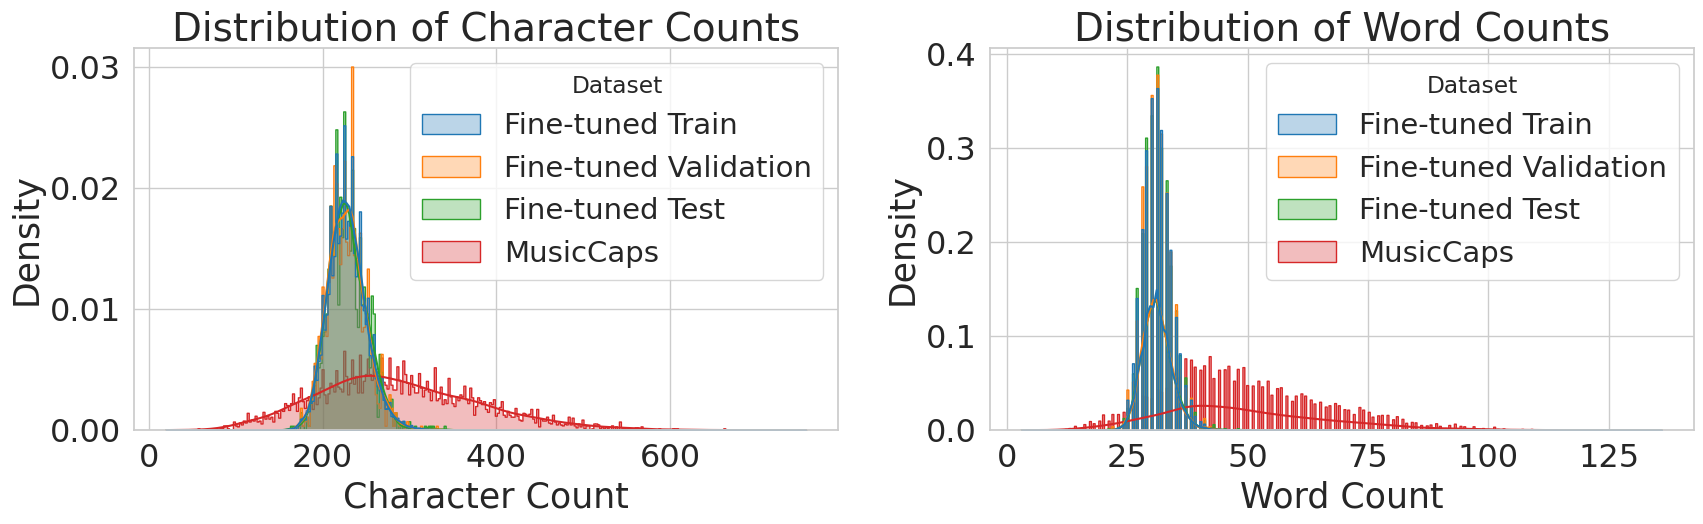

In [10]:
# Prepare data for comparison
comparison_data = []
datasets = ['train', 'validation', 'test', 'mc']
split_to_name = {
    'train': 'Fine-tuned Train',
    'validation': 'Fine-tuned Validation',
    'test': 'Fine-tuned Test',
    'mc': 'MusicCaps'
}

for dataset in datasets:
    df = predictions[dataset]
    col_name = 'prediction' if 'prediction' in df.columns else 'caption'
    df[col_name] = df[col_name].astype(str)
    
    word_counts = df[col_name].apply(lambda x: len(x.split()))
    char_counts = df[col_name].apply(len)
    
    # Create temporary dataframe for plotting
    temp_df = pd.DataFrame({
        'Dataset': split_to_name[dataset],
        'Word Count': word_counts,
        'Character Count': char_counts
    })
    comparison_data.append(temp_df)

display(temp_df)
viz_df = pd.concat(comparison_data, ignore_index=True)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(
    data=viz_df, 
    x='Character Count', 
    hue='Dataset', 
    kde=True, 
    element='step', 
    stat='density', 
    common_norm=False,
    alpha=0.3, 
    ax=axes[0]
)
axes[0].set_title('Distribution of Character Counts')
axes[0].set_xlabel('Character Count')

sns.histplot(
    data=viz_df, 
    x='Word Count', 
    hue='Dataset', 
    kde=True, 
    element='step', 
    stat='density', 
    common_norm=False,
    alpha=0.3,
    ax=axes[1]
)
axes[1].set_title('Distribution of Word Counts')
axes[1].set_xlabel('Word Count')

plt.tight_layout()
plt.show()

In [11]:
# Analyze final inference predictions
for split, df in predictions.items():
    print(f"{split} - Avg Prediction Length: {df['prediction'].astype(str).apply(len).mean()}")

train - Avg Prediction Length: 228.19232025381422
validation - Avg Prediction Length: 227.88832913518053
test - Avg Prediction Length: 228.8094038623006


KeyError: 'prediction'

In [ ]:
# Analyze word amount in captions
for split, df in predictions.items():
    df['word_count'] = df['prediction'].astype(str).apply(lambda x: len(x.split()))
    print(f"{split} - Avg Word Count: {df['word_count'].mean()}")

train - Avg Word Count: 69.15224187001353
validation - Avg Word Count: 69.37027707808564
test - Avg Word Count: 69.21158690176323


In [12]:
hf_dataset_dict = DatasetDict({ split: datasets[split] for split in splits })
hf_dataset_dict.push_to_hub("bsienkiewicz/final-caption-inference-dataset")

TypeError: list indices must be integers or slices, not str